## Importing the necessary modules

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import set_option
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold # for cross validation
from sklearn.model_selection import GridSearchCV # for tuning parameter
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.
from sklearn.preprocessing import StandardScaler, OneHotEncoder # for normalization
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # to the check the error and accuracy of the model
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Importing the datasets

In [187]:
train = pd.read_csv('train_s3TEQDk.csv')
test = pd.read_csv('test_mSzZ8RL.csv')

In [188]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [189]:
test.tail()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
105307,DBENJOYI,Male,52,RG268,Salaried,X2,86,Yes,4242558,Yes
105308,CWQ72DWS,Male,55,RG277,Other,X2,86,Yes,1159153,No
105309,HDESC8GU,Male,35,RG254,Salaried,X4,15,No,1703727,No
105310,2PW4SFCA,Male,53,RG254,Other,X3,93,No,737178,Yes
105311,F2NOYPPZ,Male,27,RG256,Salaried,X1,21,No,591565,No


In [190]:
train.shape, test.shape

((245725, 11), (105312, 10))

In [191]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               -

(None, None)

Following are the details about the column:
- ID - Unique Identifier for a row
- Gender - Gender of the Customer. This needs to be converted to categorical variable.
- Age - Age of the Customer (in Years)
- Region_code - Code of the Region for the customers. Since this deals with the region to which customer belong, should convert this to categorcial variable.
- Ocuupation - Occupation Type for the customer.
- Channel_code - Acquisition Channel Code for the Customer  (Encoded)
- Vintage - Vintage for the Customer (In Months)
- Credit_product - If the Customer has any active credit product (Home loan,Personal loan, Credit Card etc.)
- Avg_Account_Balance - Average Account Balance for the Customer in last 12 Months.
- Is_Active - If the Customer is Active in last 3 Months.
- Is_Lead(Target) - If the Customer is interested for the Credit Card
                    0 : Customer is not interested
                    1 : Customer is interested

From the above, need to convert Gender, Region_code, Occupation, Channel_code, Credit_Product, Is_Active

In [192]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = ((data.isnull().sum()/data.isnull().count())*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(train)

,Total,Percent
Credit_Product,29325,11.93407
ID,0,0.00000
Gender,0,0.00000
Age,0,0.00000
Region_Code,0,0.00000
Occupation,0,0.00000
Channel_Code,0,0.00000
Vintage,0,0.00000
Avg_Account_Balance,0,0.00000
Is_Active,0,0.00000


In [193]:
missing_data(test)

,Total,Percent
Credit_Product,12522,11.89038
ID,0,0.00000
Gender,0,0.00000
Age,0,0.00000
Region_Code,0,0.00000
Occupation,0,0.00000
Channel_Code,0,0.00000
Vintage,0,0.00000
Avg_Account_Balance,0,0.00000
Is_Active,0,0.00000


So we have almost 12% of missing values in credit_product in both test and train set.

In [194]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.00000,245725.00000,245725.00000,245725.00000
mean,43.85631,46.95914,1128403.10102,0.23721
std,14.82867,32.35314,852936.35607,0.42537
min,23.00000,7.00000,20790.00000,0.00000
25%,30.00000,20.00000,604310.00000,0.00000
50%,43.00000,32.00000,894601.00000,0.00000
75%,54.00000,73.00000,1366666.00000,0.00000
max,85.00000,135.00000,10352009.00000,1.00000


In [195]:
all_df = [train, test]

In [196]:
to_category = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
for feat in to_category:
    for data in all_df:
        data[feat] = data[feat].astype('category')

train['Is_Lead'] = train['Is_Lead'].astype('category')

In [197]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   ID                   105312 non-null  object  
 1   Gender               105312 non-null  category
 2   Age                  105312 non-null  int64   
 3   Region_Code          105312 non-null  category
 4   Occupation           105312 non-null  category
 5   Channel_Code         105312 non-null  category
 6   Vintage              105312 non-null  int64   
 7   Credit_Product       92790 non-null   category
 8   Avg_Account_Balance  105312 non-null  int64   
 9   Is_Active            105312 non-null  category
dtypes: category(6), int64(3), object(1)
memory usage: 3.8+ MB


In [198]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   ID                   245725 non-null  object  
 1   Gender               245725 non-null  category
 2   Age                  245725 non-null  int64   
 3   Region_Code          245725 non-null  category
 4   Occupation           245725 non-null  category
 5   Channel_Code         245725 non-null  category
 6   Vintage              245725 non-null  int64   
 7   Credit_Product       216400 non-null  category
 8   Avg_Account_Balance  245725 non-null  int64   
 9   Is_Active            245725 non-null  category
 10  Is_Lead              245725 non-null  category
dtypes: category(7), int64(3), object(1)
memory usage: 9.1+ MB


In [199]:
def UVA_numeric(data, var_group):
  '''
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,3), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    mini = data[i].min()
    maxi = data[i].max()
    ran = data[i].max()-data[i].min()
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()
    kurt = data[i].kurtosis()

    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(data[i], shade=True)
    sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
    sns.scatterplot([mini,maxi], [0,0], color = 'orange', label = "min/max")
    sns.scatterplot([mean], [0], color = 'red', label = "mean")
    sns.scatterplot([median], [0], color = 'blue', label = "median")
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.ylabel('density')
    plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurt,2),
                                                                                                   round(skew,2),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),
                                                                                                   round(median,2)))

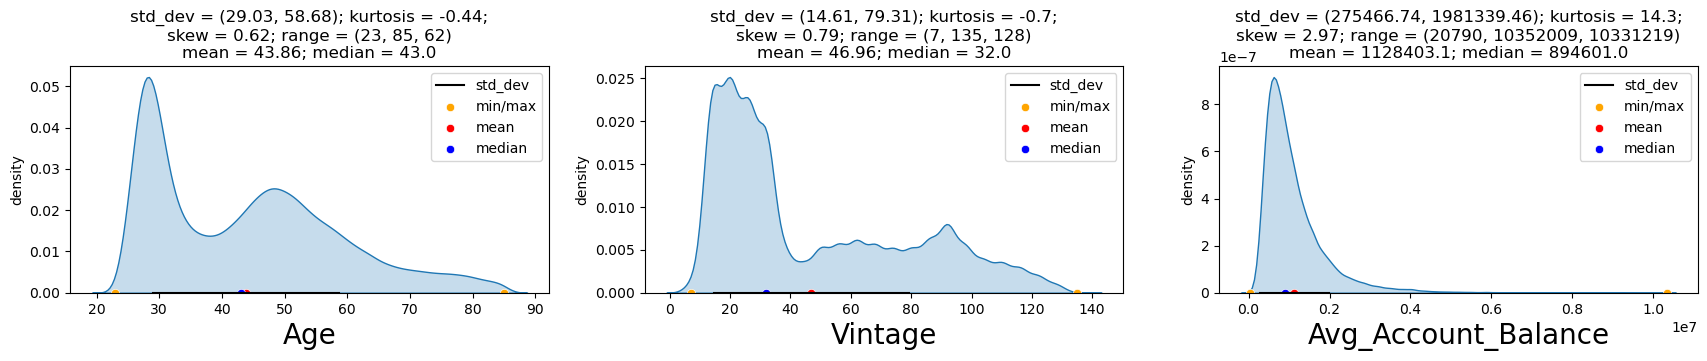

In [200]:
UVA_numeric(train,train.select_dtypes(include='int64').columns)

**Age:**
* Median age is 43
* Most of the customers are between age 29 to 58
* kurtosis = -0.44; very less likely to have extreme values
* skewness = 0.62; age is slightly biased to younger age

**Vintage:**
* Median vintage is 32
* Most customers are joined between 14 to 79 months
* kurtosis = -0.7; very likely to have extreme values
* skewness = 0.79; vintage is slightly biased to new customers.

**Avg Account balance:**
* Median vintage is 1128403.1
* Most customers have balance between 275466 to 1981339.
* kurtosis = 14.3;  Extreme values are present.
* skewness = 2.97; significantly biased towards lower account balance.

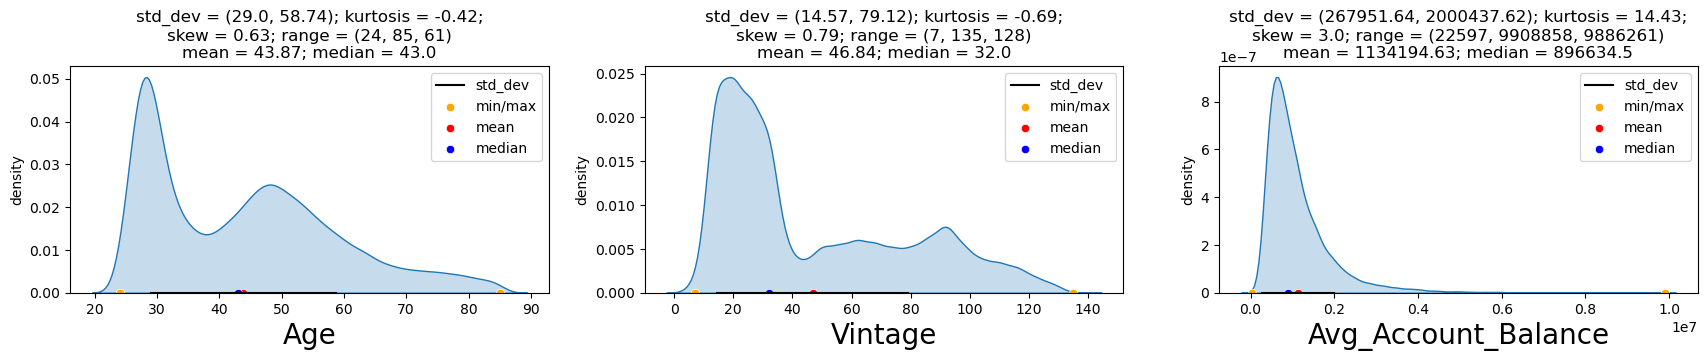

In [201]:
UVA_numeric(test,test.select_dtypes(include='int64').columns)

In [202]:
# Custom function for easy visualisation of Categorical Variables
def UVA_category(data, var_group):

  '''
  Univariate_Analysis_categorical
  takes a group of variables (category) and plot/print all the value_counts and barplot.
  '''
  # setting figure_size
  size = len(var_group)
  plt.figure(figsize = (7*size,5), dpi = 100)

  # for every variable
  for j,i in enumerate(var_group):
    norm_count = data[i].value_counts(normalize = True)
    n_uni = data[i].nunique()

  #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.barplot(norm_count, norm_count.index , order = norm_count.index)
    plt.xlabel('fraction/percent', fontsize = 20)
    plt.ylabel('{}'.format(i), fontsize = 20)
    plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))

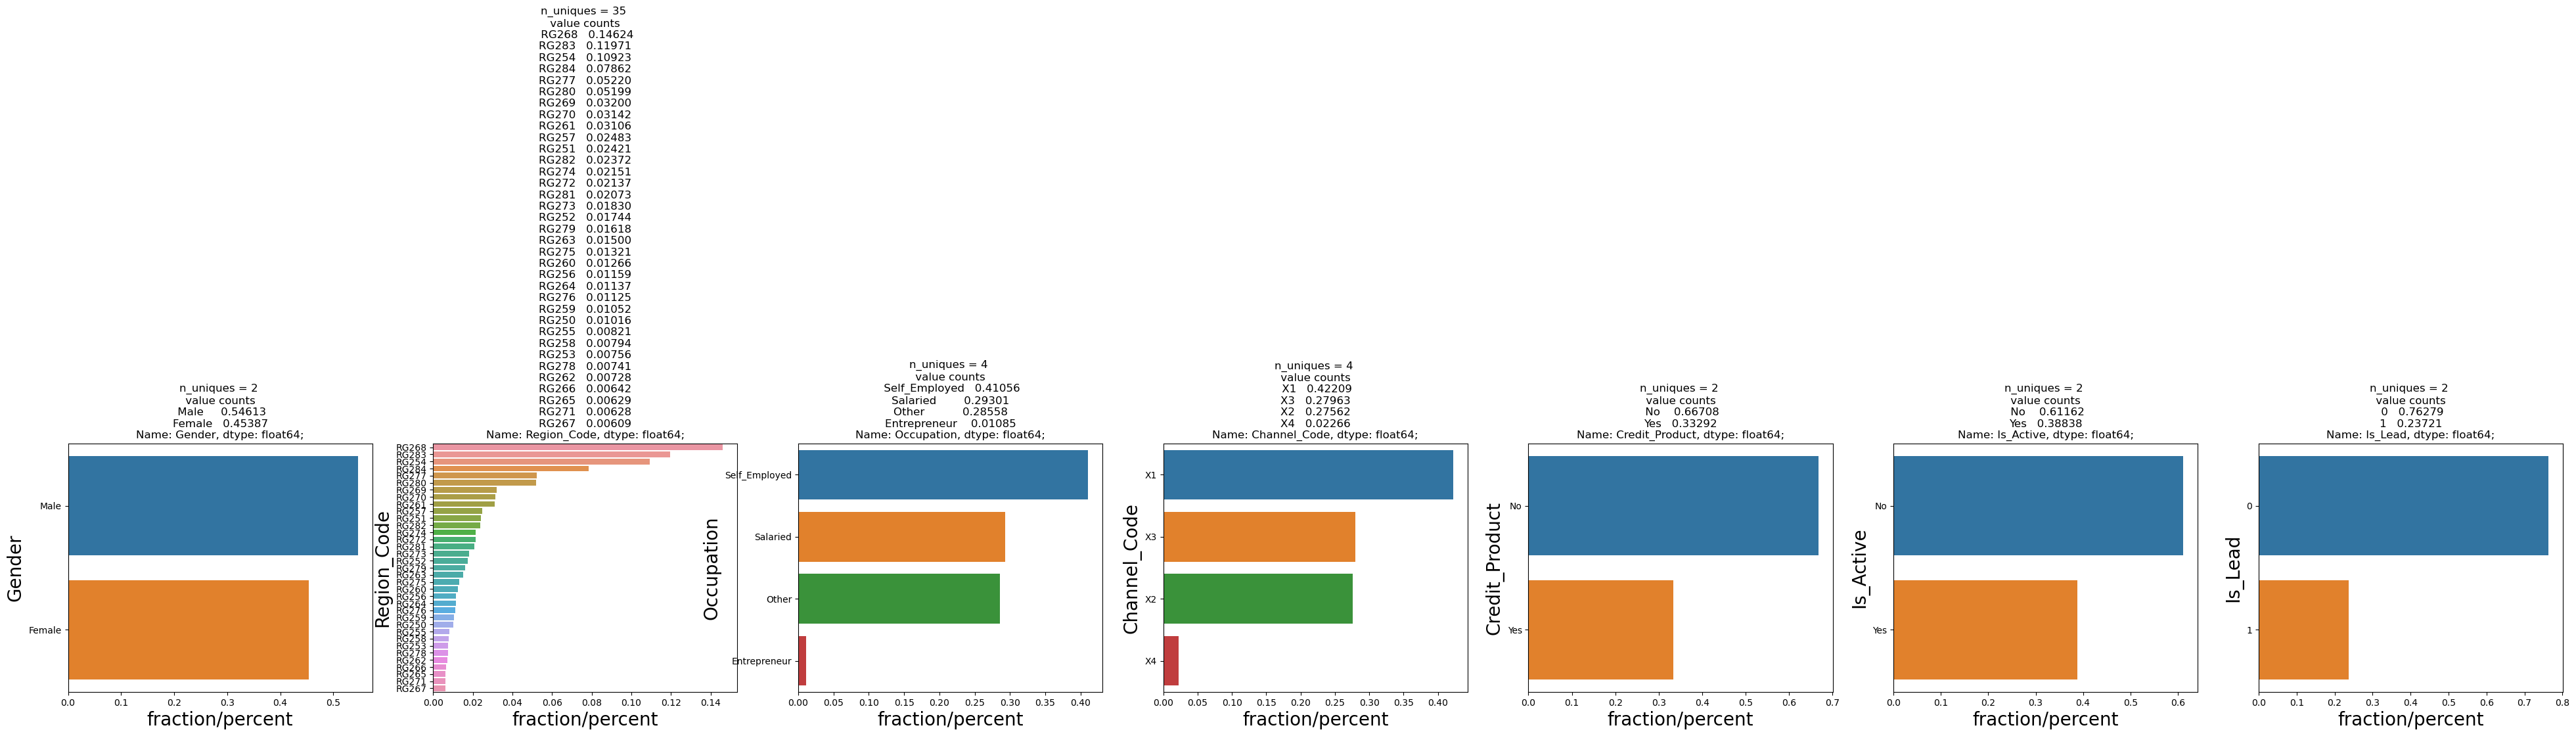

In [203]:
UVA_category(train, train.select_dtypes(include='category').columns)

**Gender:**
Male customer accounts for 1.2 times more than female.

**Region_code:**
Out of the 35 regions, 5 regions alone account for 55% of customers.

**Occupation:**
* Majority of people are self_employed.
* There are extremely few Entrepreneur. Might explain Outlier/Extreme values in credit/debit.

**Credict product:**
Majority of the customers are currently not having any credit products

**Is active:**
Majority of the customers are not active

**Is lead:**
* Most of the customers are not interested in the credit card.
* Customers who are not interested can be explained by less number of active customers.
* From the percentage values, the dataset is highly imbalanced.

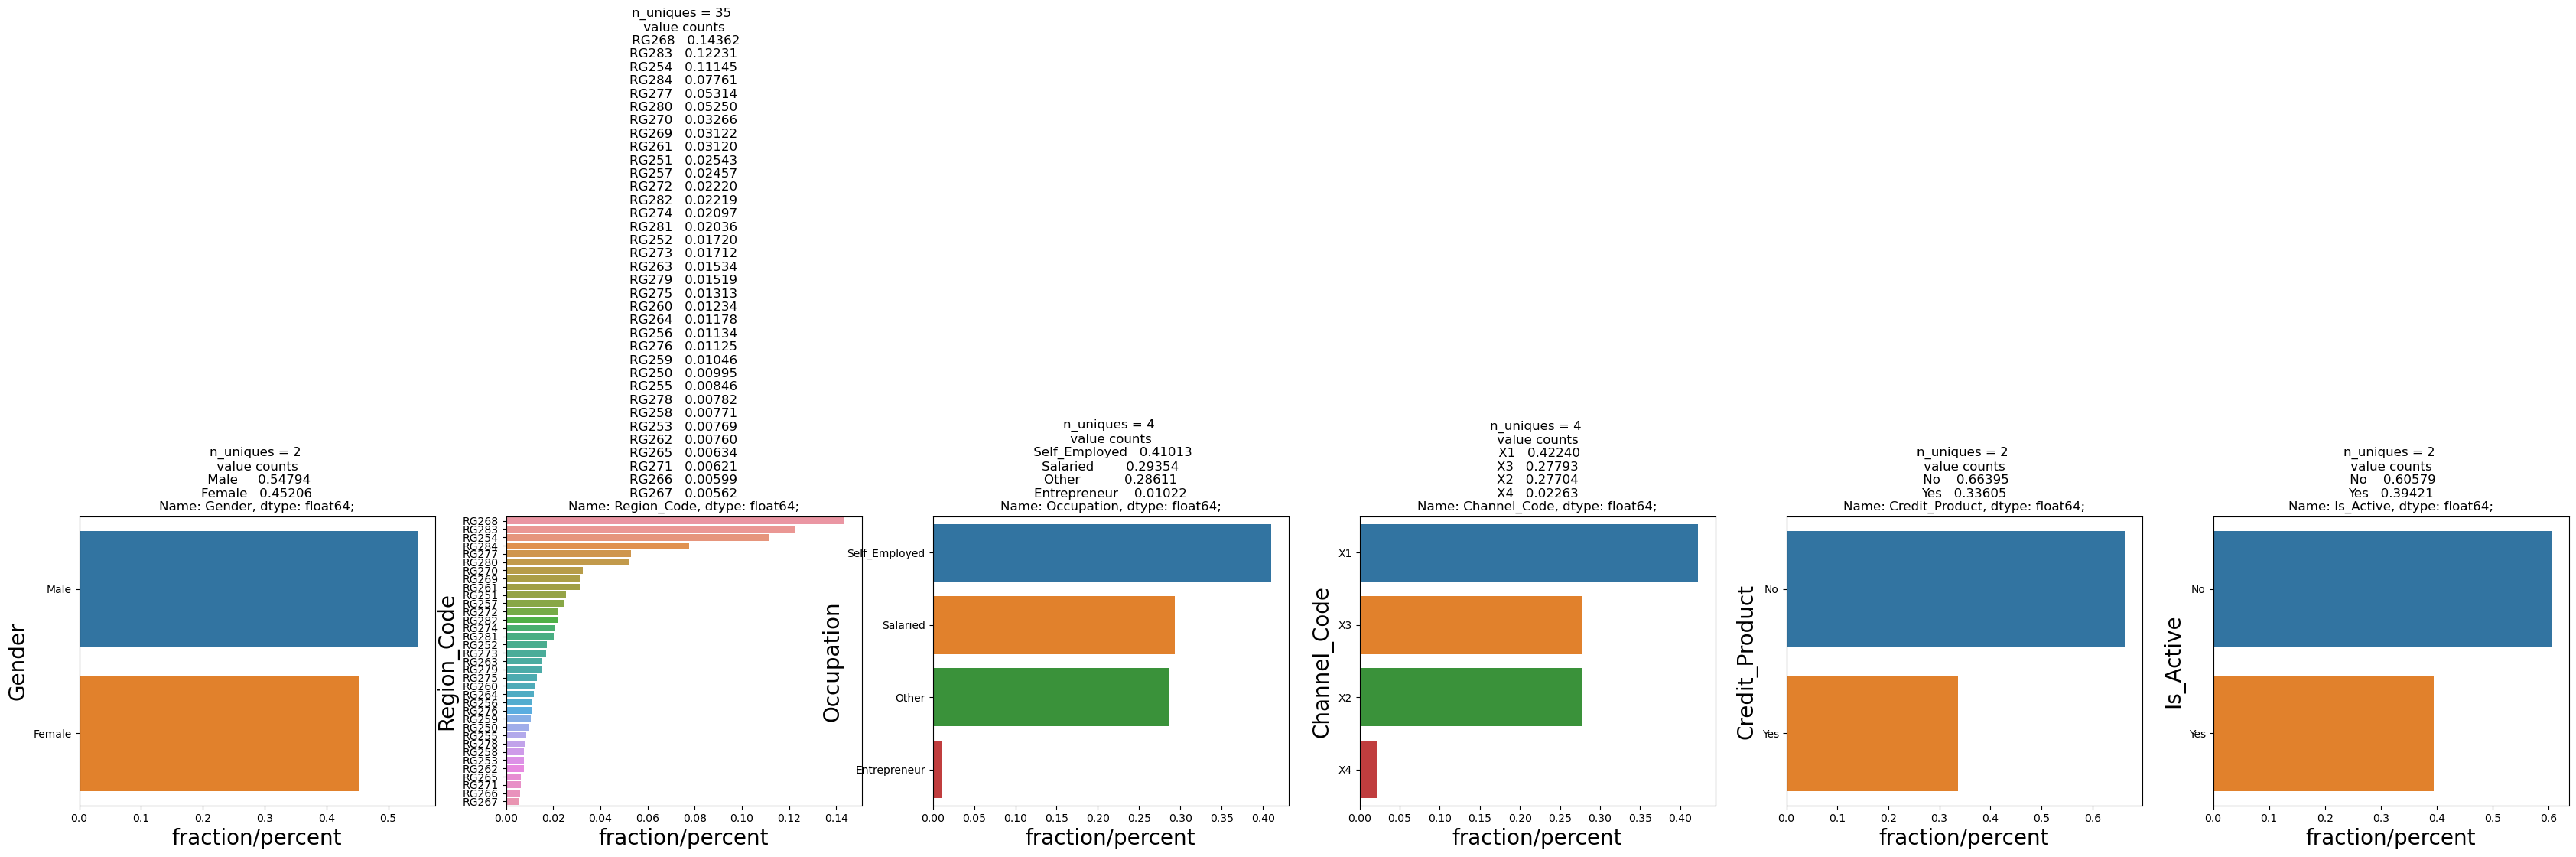

In [204]:
UVA_category(test, test.select_dtypes(include='category').columns)

## Investigation directions from Univariate analysis

1. customer_id can be dropped.
2. Occupation can explain the higher avg account balance customers.
3. Lower avg account balance can be explained by the high number of inactive customers.
4. Person with no credit product can be explained with the occuption and inactivity.

In [205]:
train.drop(['ID'], axis=1, inplace=True)

In [206]:
train.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


## Bivariate analysis

In [207]:
# Function to group all the column based on Is_Lead
def get_is_lead_categories(data, val):
    tmp = data.groupby('Is_Lead')[val].value_counts()
    return pd.DataFrame(data={'Number': tmp.values}, index=tmp.index).reset_index()

In [208]:
get_is_lead_categories(train, 'Occupation')

,Is_Lead,Occupation,Number
0,0,Self_Employed,73045
1,0,Salaried,60503
2,0,Other,52984
3,0,Entrepreneur,905
4,1,Self_Employed,27841
5,1,Other,17189
6,1,Salaried,11496
7,1,Entrepreneur,1762


In [209]:
train.select_dtypes(include='category').columns

Index(['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product',
       'Is_Active', 'Is_Lead'],
      dtype='object')

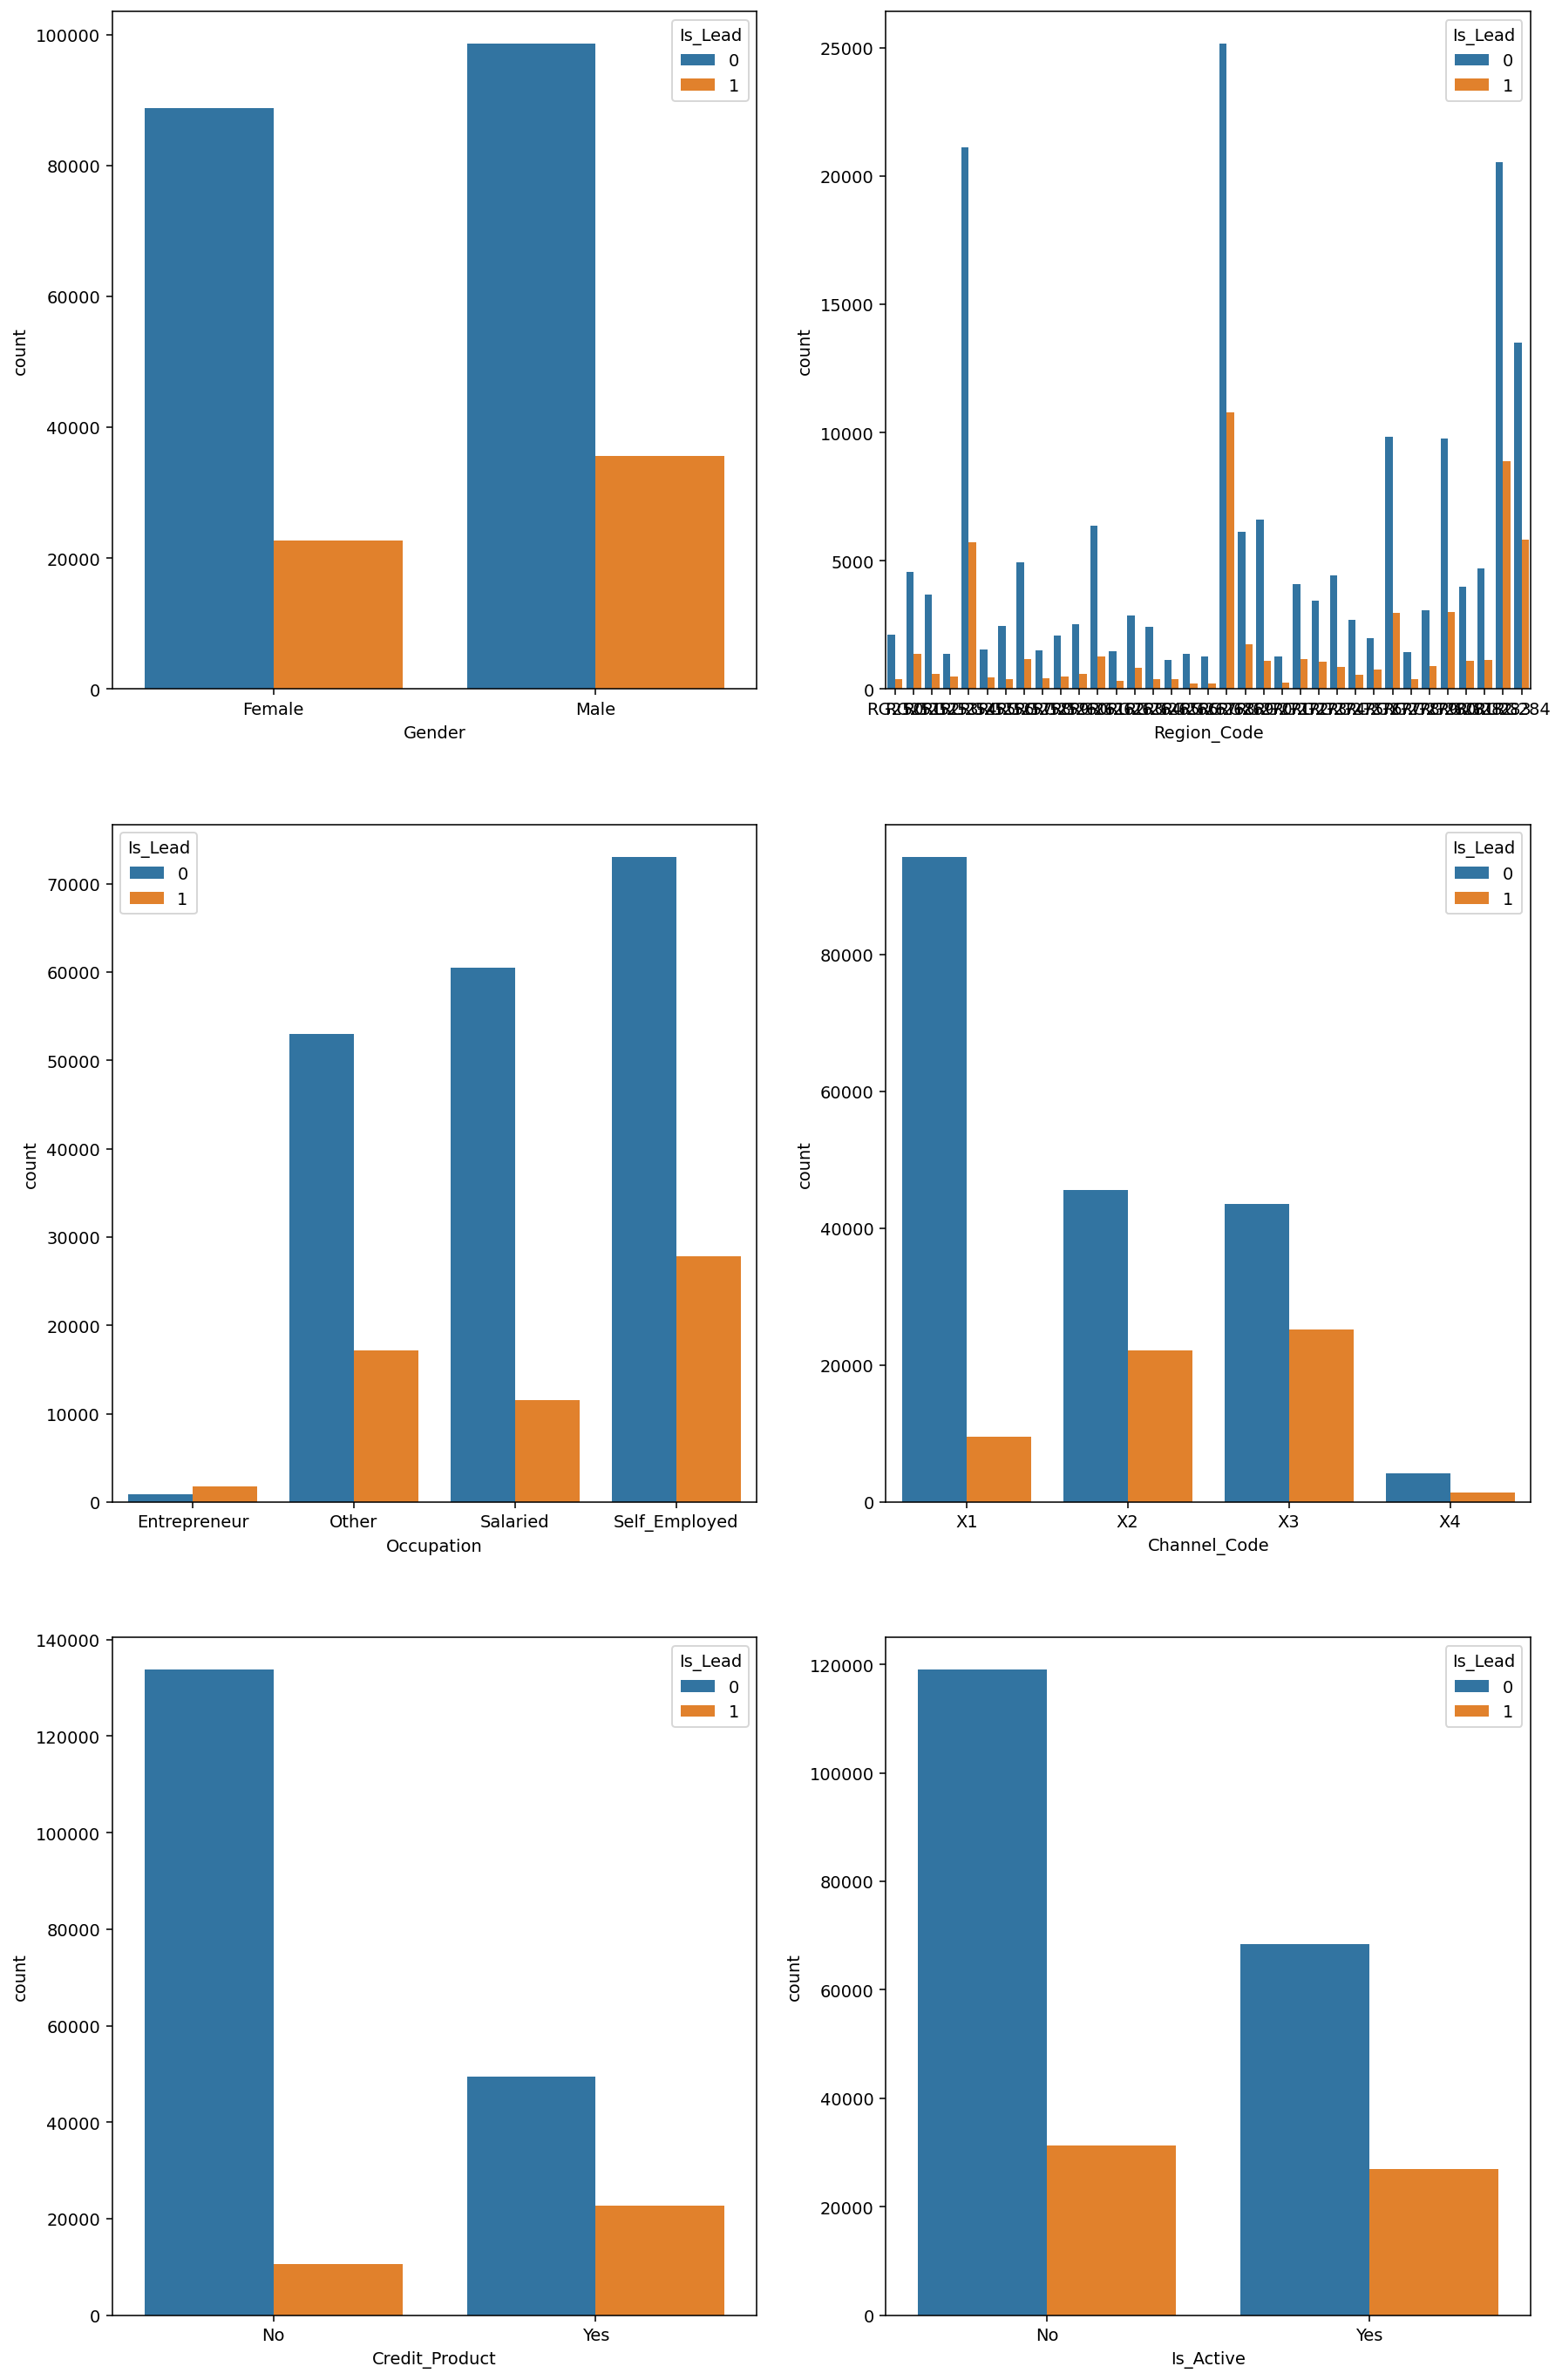

In [210]:
cat_cols = train.select_dtypes(include='category').columns.drop('Is_Lead')
plt.figure(figsize=(15,25), dpi=140)
for i, cols in enumerate(cat_cols):
    plt.subplot(int(len(cat_cols)/2), 2, i+1)
    sns.countplot(x=cols, hue='Is_Lead', data=train)

<Figure size 3500x2800 with 0 Axes>

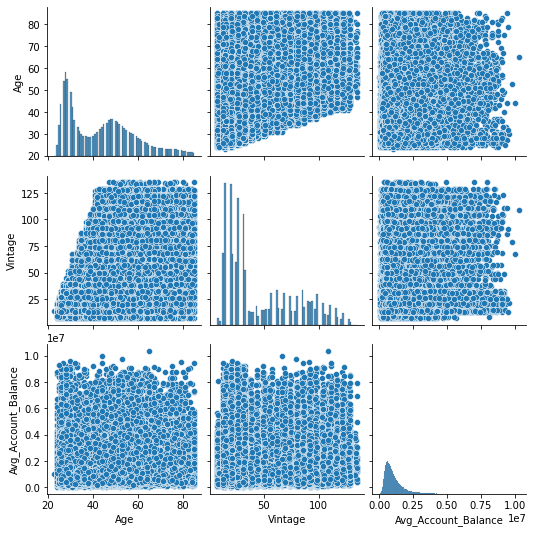

In [211]:
plt.figure(figsize=(25,20), dpi=140)
numer_cols = train.select_dtypes(include='int64').columns
sns.pairplot(train[numer_cols]);

From above plots, can confirm that there is no correlation between the numerical columns

<Figure size 1080x1080 with 0 Axes>

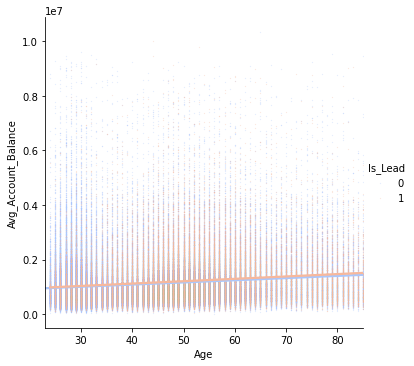

In [212]:
plt.figure(figsize=(15,15))
sns.lmplot(data=train, x='Age', y='Avg_Account_Balance', hue='Is_Lead', palette='coolwarm', scatter_kws={"s": 0.02})

From above plot, couldn't distinguish between lead or not. So avg_account_balance and age are correlated

## Outlier in average account balance

Now can investigate if the outliers in account balance is due to occupation.

In [213]:
train.groupby('Occupation')['Avg_Account_Balance'].median()

Occupation
Entrepreneur     1182890
Other             959188
Salaried          811991
Self_Employed     909072
Name: Avg_Account_Balance, dtype: int64

<AxesSubplot:xlabel='Occupation', ylabel='Avg_Account_Balance'>

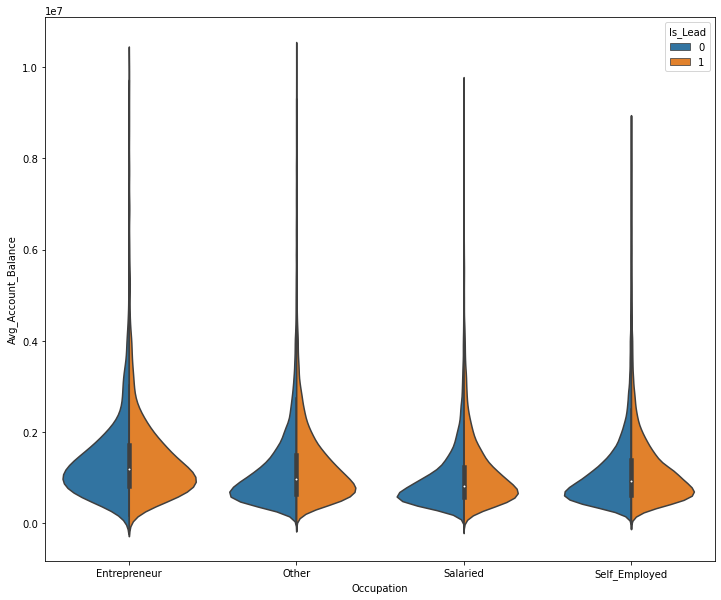

In [214]:
plt.figure(figsize=(12,10))
sns.violinplot(data=train, x='Occupation', y='Avg_Account_Balance', hue='Is_Lead', split=True)

Almost customers with all the occupation has outlier values in which we can see Other and Entrepreneurs have more outlier values. But the median Avg_account balance is more for entrepreneurs. Also the credit card interested people, have fatter tails.

## Lower account balance with inactive customers

<AxesSubplot:xlabel='Is_Active', ylabel='Avg_Account_Balance'>

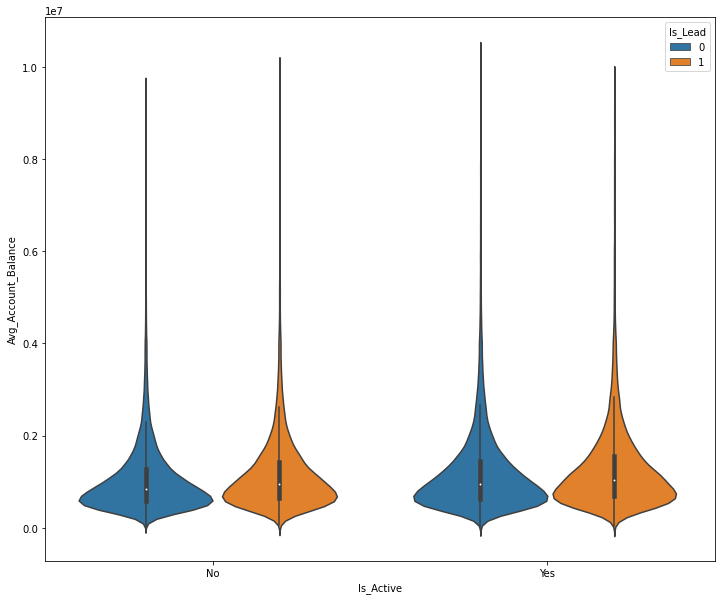

In [215]:
plt.figure(figsize=(12,10))
sns.violinplot(data=train, x='Is_Active', y='Avg_Account_Balance', hue='Is_Lead')

Both active and inactive customers have similar account balance plots i.e both the categories have same lower and almost same higher amount. Also the credit card interested people have fatter tails

In [216]:
train.groupby(['Is_Active','Is_Lead'])['Avg_Account_Balance'].median()

Is_Active  Is_Lead
No         0           831936
           1           944619
Yes        0           943497
           1          1027442
Name: Avg_Account_Balance, dtype: int64

## No credit_product vs in active vs occupation

From the univariate analysis, can see that almost 1/3 has credit products. will try to explain that through occupaiton and activity

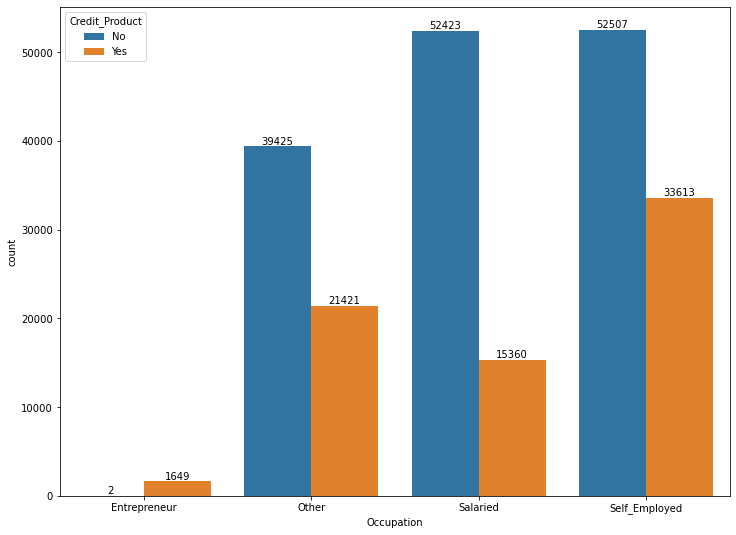

In [217]:
plt.figure(figsize=(12,9))
cplot = sns.countplot(data=train, x='Occupation', hue='Credit_Product')
for count in cplot.patches:
    height = count.get_height()
    plt.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')

From above plot can see that majority of non credit product holders are in self-employed, salaried and other categories.

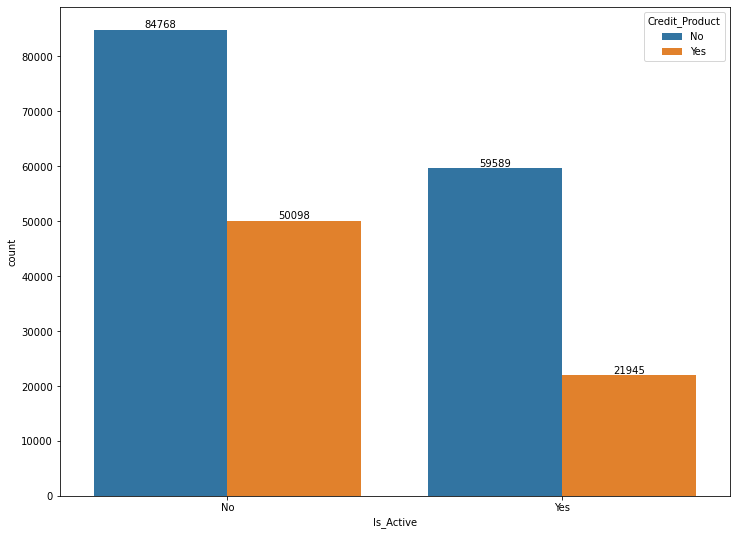

In [218]:
plt.figure(figsize=(12,9))
cplot = sns.countplot(data=train, x='Is_Active', hue='Credit_Product')
for count in cplot.patches:
    height = count.get_height()
    plt.annotate('{}'.format(height),xy=(count.get_x() + count.get_width()/2, height),
                    ha='center', va='bottom')

From above plot can see that, some of the inactive accounts also has credit products

## Impute missing values

In our case, we have missing data only in Credit_Product (11%). Lets now impute the occupation specific mode

In [219]:
group_mean = train.groupby('Occupation')['Credit_Product'].agg(pd.Series.mode)
missing_credit = train.loc[train.Credit_Product.isna()==True]
missing_credit['Credit_Product']=missing_credit.apply(lambda row: group_mean[row['Occupation']], axis=1)
train.drop(missing_credit.index, inplace=True)
train = pd.concat([train, missing_credit], ignore_index=True)

<ipython-input-219-93bd477a079d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_credit['Credit_Product']=missing_credit.apply(lambda row: group_mean[row['Occupation']], axis=1)


In [220]:
train.isna().sum()

Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

Now have successfully imputed the group specific mode into the missing column. Lets start building our model.

Now lets impute the missing values in test dataset also with the same mode

In [221]:
missing_credit = test.loc[test.Credit_Product.isna()==True]
missing_credit['Credit_Product']=missing_credit.apply(lambda row: group_mean[row['Occupation']], axis=1)
test.drop(missing_credit.index, inplace=True)
test = pd.concat([test, missing_credit], ignore_index=True)

<ipython-input-221-c9f682f6757c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_credit['Credit_Product']=missing_credit.apply(lambda row: group_mean[row['Occupation']], axis=1)


In [222]:
test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
2,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
3,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No
4,MZZAQMPT,Male,60,RG268,Self_Employed,X3,110,No,4624262,No


## Encoding the data

In [223]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Gender               245725 non-null  category
 1   Age                  245725 non-null  int64   
 2   Region_Code          245725 non-null  category
 3   Occupation           245725 non-null  category
 4   Channel_Code         245725 non-null  category
 5   Vintage              245725 non-null  int64   
 6   Credit_Product       245725 non-null  object  
 7   Avg_Account_Balance  245725 non-null  int64   
 8   Is_Active            245725 non-null  category
 9   Is_Lead              245725 non-null  category
dtypes: category(6), int64(3), object(1)
memory usage: 8.9+ MB


Now the Credit_Product has change to object dtype. Lets change to category

In [224]:
train['Credit_Product'] = train['Credit_Product'].astype('category')
test['Credit_Product'] = test['Credit_Product'].astype('category')

In [225]:
Y = train['Is_Lead']
X = train.drop('Is_Lead', axis=1)

In [226]:
def encode_cats(data,categoricals):
    """
    Takes in a list of categorical columns and a list of numerical columns and returns the dataframe with encoded variables
    """
    ohe = OneHotEncoder(sparse=False, drop='first')
    cat_matrix = ohe.fit_transform(data.loc[:, categoricals])
    X_ohe = pd.DataFrame(cat_matrix,
                         columns=ohe.get_feature_names(categoricals), #create meaningful column names
                         index=data.index) #keep the same index values
    data.drop(categoricals, axis=1, inplace=True)
    return pd.concat([data, X_ohe], axis=1)

In [227]:
categoricals = list(X.select_dtypes('category').columns)
X = encode_cats(X, categoricals)

In [228]:
X.head()

,Age,Vintage,Avg_Account_Balance,Gender_Male,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,...,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_Yes,Is_Active_Yes
0,73,43,1045696,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
1,30,32,581988,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,56,26,1484315,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000
3,34,19,470454,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,30,33,886787,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [229]:
categoricals_test = list(test.select_dtypes('category').columns)
test = encode_cats(test, categoricals_test)

In [230]:
test.head()

,ID,Age,Vintage,Avg_Account_Balance,Gender_Male,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,...,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_Yes,Is_Active_Yes
0,VBENBARO,29,25,742366,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
1,VK3KGA9M,31,14,215949,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,TT8RPZVC,29,33,868070,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,SHQZEYTZ,29,19,657087,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,MZZAQMPT,60,110,4624262,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000


## Split the data

In [231]:
#We are using 80-20 split for train-test
VALID_SIZE = 0.2
#We also use random state for reproducibility
RANDOM_STATE = 2018

train_X, valid_X, train_Y, valid_Y = train_test_split(X,Y, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [232]:
train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape, test.shape

((196580, 46), (196580,), (49145, 46), (49145,), (105312, 47))

In [48]:
test.head()

,ID,Age,Vintage,Avg_Account_Balance,Gender_Male,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,...,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_Yes,Is_Active_Yes
0,VBENBARO,29,25,742366,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
1,VK3KGA9M,31,14,215949,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,TT8RPZVC,29,33,868070,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,SHQZEYTZ,29,19,657087,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,MZZAQMPT,60,110,4624262,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000


## Encoded data

In [49]:
def scale_data(X_train, X_val, X_test):
    """
    Input: Features (numpy arrays)
    Output: Scaled data
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index= X_train.index)
    X_val_scaled = scaler.transform(X_val)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index= X_val.index)
    X_test_scaled = scaler.transform(X_test.iloc[:,1:])
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.iloc[:,1:].columns, index= X_test.iloc[:,1:].index)
    X_test_scaled = pd.concat([X_test.iloc[:,0], X_test_scaled], axis=1)
    return X_train_scaled, X_val_scaled, X_test_scaled

In [50]:
train_x_scaled, val_X_scaled, test_scaled= scale_data(train_X, valid_X, test)

In [83]:
test_scaled.head()

,ID,Age,Vintage,Avg_Account_Balance,Gender_Male,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,...,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_Yes,Is_Active_Yes
0,VBENBARO,-1.00223,-0.67882,-0.45254,0.91214,-0.15768,-0.13273,-0.08659,2.84866,-0.09152,...,-0.36857,-0.29216,1.58382,-0.64384,-0.83542,-0.61782,-0.62173,-0.15283,1.53847,-0.79633
1,VK3KGA9M,-0.86731,-1.01893,-1.07049,0.91214,-0.15768,-0.13273,-0.08659,-0.35104,-0.09152,...,-0.36857,-0.29216,-0.63139,1.55318,-0.83542,-0.61782,-0.62173,-0.15283,-0.64999,-0.79633
2,TT8RPZVC,-1.00223,-0.43147,-0.30498,0.91214,-0.15768,-0.13273,-0.08659,-0.35104,-0.09152,...,-0.36857,-0.29216,1.58382,-0.64384,-0.83542,-0.61782,-0.62173,-0.15283,-0.64999,-0.79633
3,SHQZEYTZ,-1.00223,-0.86433,-0.55265,-1.09632,-0.15768,-0.13273,-0.08659,-0.35104,-0.09152,...,-0.36857,-0.29216,1.58382,-0.64384,-0.83542,-0.61782,-0.62173,-0.15283,-0.64999,-0.79633
4,MZZAQMPT,1.08902,1.94928,4.10436,0.91214,-0.15768,-0.13273,-0.08659,-0.35104,-0.09152,...,-0.36857,-0.29216,-0.63139,-0.64384,1.19701,-0.61782,1.60842,-0.15283,-0.64999,-0.79633


## Random Forest model

From our analysis, can see Credit_products, Is_Active, Occupation, avg_account_balance have significant effect on the target variable.

In [131]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier
RANDOM_STATE = 2018
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result
#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

In [54]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [55]:
clf.fit(train_X, train_Y)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [56]:
preds = clf.predict_proba(valid_X)

In [67]:
preds_class = clf.predict(valid_X)

In [57]:
from sklearn.metrics import roc_auc_score
roc_auc_score(valid_Y.values, preds[:,1])

0.7541184445793021

In [58]:
test.head()

,ID,Age,Vintage,Avg_Account_Balance,Gender_Male,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,...,Region_Code_RG283,Region_Code_RG284,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_Yes,Is_Active_Yes
0,VBENBARO,29,25,742366,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
1,VK3KGA9M,31,14,215949,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,TT8RPZVC,29,33,868070,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,SHQZEYTZ,29,19,657087,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,MZZAQMPT,60,110,4624262,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000


In [84]:
preds_test = clf.predict_proba(test.iloc[:,1:])
test_pred = np.stack([test.ID.values,preds_test[:,1]], axis=1)
test_pred = pd.DataFrame(test_pred, columns=['ID', 'Is_Lead'])
test_pred.to_csv('submission.csv', index=False)

In [63]:
test_pred

,ID,Is_Lead
0,VBENBARO,0.0
1,VK3KGA9M,0.04
2,TT8RPZVC,0.11
3,SHQZEYTZ,0.02
4,MZZAQMPT,0.81
...,...,...
105307,ZXCWURWZ,0.99
105308,RKSESPFM,0.27
105309,EPJEMD9H,0.45
105310,GWVNNKSG,0.15


### Feature Importance

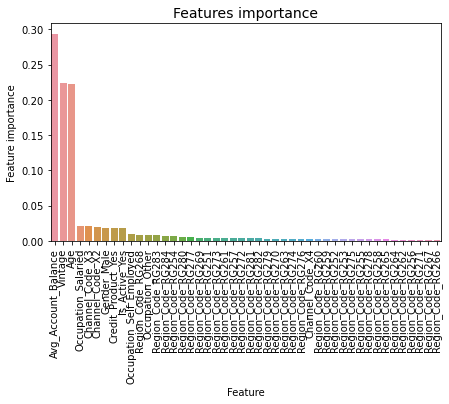

In [65]:
tmp = pd.DataFrame({'Feature': train_X.columns, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

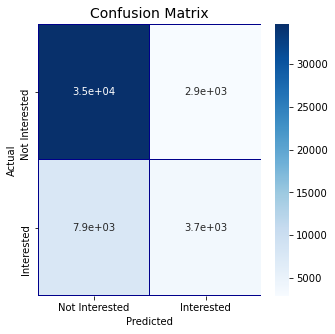

In [68]:
cm = pd.crosstab(valid_Y.values, preds_class, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Interested', 'Interested'],
            yticklabels=['Not Interested', 'Interested'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [111]:
print(classification_report(valid_Y, preds_class))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     37607
           1       0.56      0.32      0.41     11538

    accuracy                           0.78     49145
   macro avg       0.69      0.62      0.64     49145
weighted avg       0.75      0.78      0.76     49145



## Logistic Regression

In [85]:
lr = LogisticRegression(penalty='none')
lr.fit(train_x_scaled[predictors],train_Y)

LogisticRegression(penalty='none')

In [86]:
preds_lr = lr.predict_proba(val_X_scaled[predictors])
preds_lr_class = lr.predict(val_X_scaled[predictors])

In [87]:
roc_auc_score(valid_Y.values, preds_lr[:,1])

0.7007328020051072

### Confusion matrix

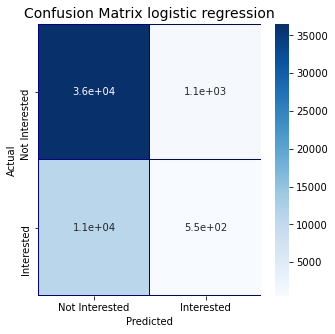

In [88]:
cm = pd.crosstab(valid_Y.values, preds_lr_class, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Interested', 'Interested'],
            yticklabels=['Not Interested', 'Interested'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix logistic regression', fontsize=14)
plt.show()

In [109]:
preds_test_lr = lr.predict_proba(test_scaled[predictors])
test_pred_lr = np.stack([test_scaled.ID.values,preds_test_lr[:,1]], axis=1)
test_pred_lr = pd.DataFrame(test_pred_lr, columns=['ID', 'Is_Lead'])
test_pred_lr.to_csv('submission_lr.csv', index=False)

### classification report

In [112]:
print(classification_report(valid_Y, preds_lr_class))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86     37607
           1       0.33      0.05      0.08     11538

    accuracy                           0.75     49145
   macro avg       0.55      0.51      0.47     49145
weighted avg       0.67      0.75      0.68     49145



## AdaBoost classifier

In [115]:
clf_abc = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [117]:
clf_abc.fit(train_X, train_Y)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [121]:
preds_abc = clf_abc.predict_proba(valid_X)

In [122]:
preds_class_abc = clf_abc.predict(valid_X)

In [123]:
from sklearn.metrics import roc_auc_score
roc_auc_score(valid_Y.values, preds_abc[:,1])

0.76403976883054

### submission

In [124]:
preds_test_abc = clf_abc.predict_proba(test.iloc[:,1:])
test_pred_abc = np.stack([test.ID.values,preds_test[:,1]], axis=1)
test_pred_abc = pd.DataFrame(test_pred_abc, columns=['ID', 'Is_Lead'])
test_pred_abc.to_csv('submission_abc.csv', index=False)

### Feature Importance

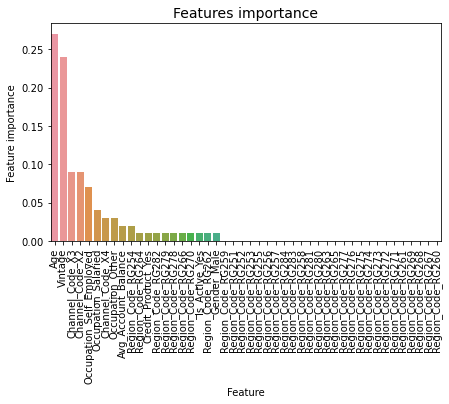

In [126]:
tmp = pd.DataFrame({'Feature': train_X.columns, 'Feature importance': clf_abc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

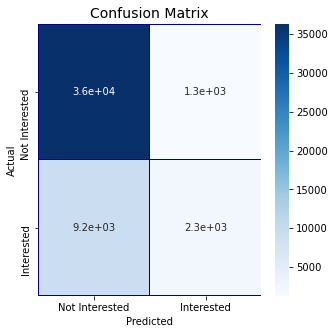

In [127]:
cm = pd.crosstab(valid_Y.values, preds_class_abc, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Interested', 'Interested'],
            yticklabels=['Not Interested', 'Interested'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [128]:
print(classification_report(valid_Y, preds_class_abc))

              precision    recall  f1-score   support

           0       0.80      0.97      0.87     37607
           1       0.64      0.20      0.30     11538

    accuracy                           0.79     49145
   macro avg       0.72      0.58      0.59     49145
weighted avg       0.76      0.79      0.74     49145



## Catboost classifier

In [233]:
clf_cbc = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [234]:
clf_cbc.fit(train_X, train_Y, verbose=True)

0:	total: 56.5ms	remaining: 28.2s
50:	total: 9.39s	remaining: 1m 22s
100:	total: 18.7s	remaining: 1m 13s
150:	total: 28.7s	remaining: 1m 6s
200:	total: 37.9s	remaining: 56.4s
250:	total: 47s	remaining: 46.7s
300:	total: 57s	remaining: 37.7s
350:	total: 1m 6s	remaining: 28.4s
400:	total: 1m 16s	remaining: 18.8s
450:	total: 1m 26s	remaining: 9.39s
499:	total: 1m 35s	remaining: 0us


In [235]:
preds_cbc = clf_cbc.predict_proba(valid_X)
preds_cbc_class = clf_cbc.predict(valid_X)

### Feature importance

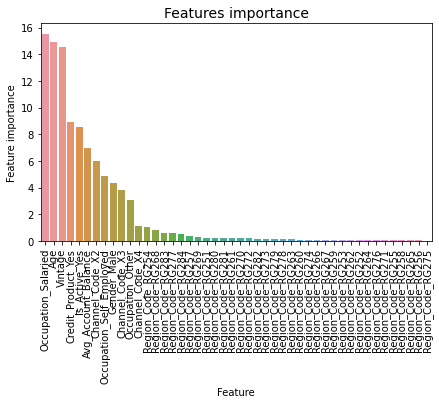

In [236]:
tmp = pd.DataFrame({'Feature': train_X.columns, 'Feature importance': clf_cbc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Confusion matrix

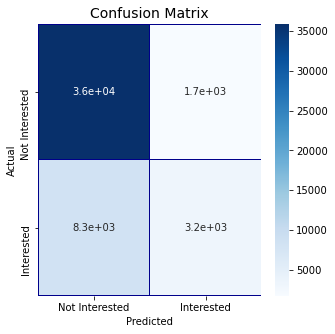

In [237]:
cm = pd.crosstab(valid_Y.values, preds_cbc_class, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Interested', 'Interested'],
            yticklabels=['Not Interested', 'Interested'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [238]:
roc_auc_score(valid_Y.values, preds_cbc[:,1])

0.7882806529321826

In [239]:
print(classification_report(valid_Y, preds_cbc_class))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88     37607
           1       0.65      0.28      0.39     11538

    accuracy                           0.80     49145
   macro avg       0.73      0.62      0.63     49145
weighted avg       0.77      0.80      0.76     49145



In [142]:
preds_test_cbc = clf_cbc.predict_proba(test.iloc[:,1:])
test_pred_cbc = np.stack([test.ID.values,preds_test_cbc[:,1]], axis=1)
test_pred_cbc = pd.DataFrame(test_pred_cbc, columns=['ID', 'Is_Lead'])
test_pred_cbc.to_csv('submission_cbc.csv', index=False)

## XGBoost

In [143]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_X, train_Y)
dvalid = xgb.DMatrix(valid_X, valid_Y)
dtest = xgb.DMatrix(test.iloc[:,1:])

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [144]:
clf_xgb = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[12:47:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.72036	valid-auc:0.72288
[50]	train-auc:0.74750	valid-auc:0.74914
[100]	train-auc:0.76054	valid-auc:0.76173
[150]	train-auc:0.76662	valid-auc:0.76768
[200]	train-auc:0.77030	valid-auc:0.77110
[250]	train-auc:0.77240	valid-auc:0.77306
[300]	train-auc:0.77359	valid-auc:0.77418
[350]	train-auc:0.77464	valid-auc:0.77521
[400]	train-auc:0.77538	valid-auc:0.77593
[450]	train-auc:0.77595	valid-auc:0.77647
[500]	train-auc:0.77644	valid-auc:0.77689
[550]	train-auc:0.77678	valid-auc:0.77714
[600]	train-auc:0.77718	valid-auc:0.77747
[650]	train-auc:0.77755	valid-auc:0.77781
[700]	train-auc:0.77781	valid

In [149]:
preds_xgb = clf_xgb.predict(dvalid)

In [150]:
roc_auc_score(valid_Y, preds_xgb)

0.7790211232632746

### Feature importance

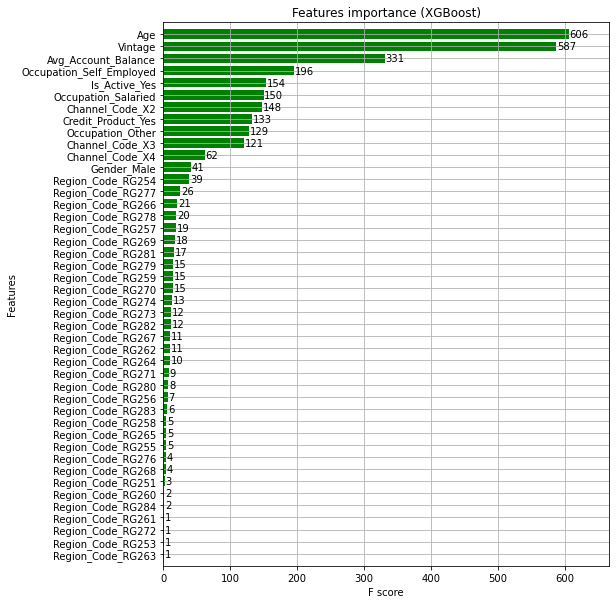

In [146]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,10))
xgb.plot_importance(clf_xgb, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

### submission

In [169]:
preds_test_xgb = clf_xgb.predict(dtest)
test_pred_xgb = np.stack([test.ID.values,preds_test[:,1]], axis=1)
test_pred_xgb = pd.DataFrame(test_pred_xgb, columns=['ID', 'Is_Lead'])
test_pred_xgb.to_csv('submission_xgb.csv', index=False)

## Feature selection

From the above models, can fetch the important features and train the catboost classifier

In [242]:
tmp = pd.DataFrame({'Feature': train_X.columns, 'Feature importance': clf_cbc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
predictors = tmp['Feature'][:11].tolist()

In [132]:
clf_cbc = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [243]:
clf_cbc.fit(train_X[predictors], train_Y, verbose=True)

0:	total: 208ms	remaining: 1m 43s
50:	total: 9.1s	remaining: 1m 20s
100:	total: 18.2s	remaining: 1m 11s
150:	total: 27.2s	remaining: 1m 2s
200:	total: 36s	remaining: 53.5s
250:	total: 44.8s	remaining: 44.4s
300:	total: 53.7s	remaining: 35.5s
350:	total: 1m 2s	remaining: 26.4s
400:	total: 1m 11s	remaining: 17.7s
450:	total: 1m 20s	remaining: 8.72s
499:	total: 1m 28s	remaining: 0us


In [244]:
preds_cbc = clf_cbc.predict_proba(valid_X[predictors])
preds_cbc_class = clf_cbc.predict(valid_X)

### Feature importance

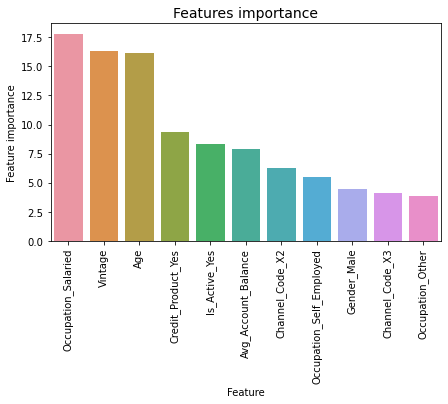

In [245]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf_cbc.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Confusion matrix

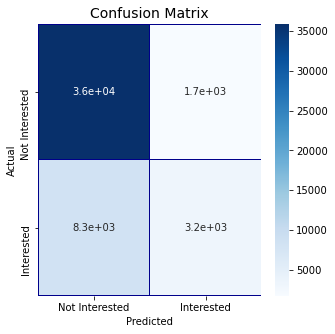

In [246]:
cm = pd.crosstab(valid_Y.values, preds_cbc_class, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Interested', 'Interested'],
            yticklabels=['Not Interested', 'Interested'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [247]:
roc_auc_score(valid_Y.values, preds_cbc[:,1])

0.7871445014420355

In [248]:
print(classification_report(valid_Y, preds_cbc_class))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88     37607
           1       0.65      0.28      0.39     11538

    accuracy                           0.80     49145
   macro avg       0.73      0.62      0.63     49145
weighted avg       0.77      0.80      0.76     49145



In [142]:
preds_test_cbc = clf_cbc.predict_proba(test.iloc[:,1:])
test_pred_cbc = np.stack([test.ID.values,preds_test_cbc[:,1]], axis=1)
test_pred_cbc = pd.DataFrame(test_pred_cbc, columns=['ID', 'Is_Lead'])
test_pred_cbc.to_csv('submission_cbc.csv', index=False)